# <u>**Lesson 1**</u>
### Huber loss:
In statistics, the Huber loss is a loss function used in robust regression, that is less sensitive to outliers in data than the squared error loss. A variant for classification is also sometimes used.
# RNN

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

If you are creating many models in a loop, this global state will consume an increasing amount of memory over time, and you may want to clear it. Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.

First of all is the tf.keras.backend.clear_session, and this clears any internal variables. That makes it easy for us to experiment without models impacting later versions of themselves.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer, metrics=["mae"])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 14ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 192.3058 - mae: 192.8058
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 183.4113 - mae: 183.9113
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 180.7795 - mae: 181.2795
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 176.5625 - mae: 177.0625
Epoch 11/100
8/8 [===========

We'll plot the results to try to find the optimal learning rate. You can see here, it's between 10_minus 6 and 10_minus 5. So I pick a value halfway say, 5 times 10_minus 5.

(1e-08, 0.0001, 0.0, 30.0)

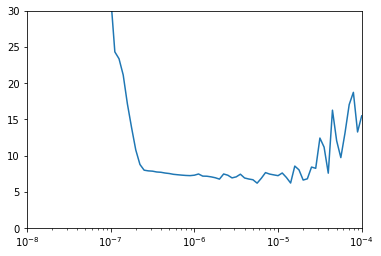

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 11ms/step - loss: 114.4029 - mae: 114.9028
Epoch 2/400
8/8 [==============================] - 0s 11ms/step - loss: 22.2724 - mae: 22.7647
Epoch 3/400
8/8 [==============================] - 0s 11ms/step - loss: 17.3886 - mae: 17.8839
Epoch 4/400
8/8 [==============================] - 0s 10ms/step - loss: 13.2059 - mae: 13.7011
Epoch 5/400
8/8 [==============================] - 0s 10ms/step - loss: 9.7416 - mae: 10.2310
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 15.0013 - mae: 15.4961
Epoch 7/400
8/8 [==============================] - 0s 12ms/step - loss: 14.9219 - mae: 15.4167
Epoch 8/400
8/8 [==============================] - 0s 11ms/step - loss: 10.2478 - mae: 10.7416
Epoch 9/400
8/8 [==============================] - 0s 11ms/step - loss: 8.0298 - mae: 8.5191
Epoch 10/400
8/8 [==============================] - 0s 11ms/step - loss: 17.0683 - mae: 17.5661
Epoch 11/400
8/8 [==============================] 

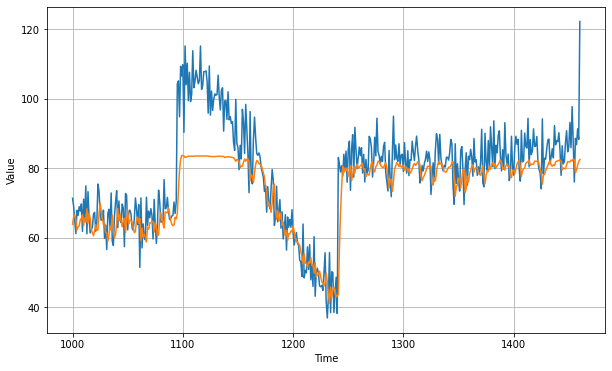

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.8579226

<Figure size 432x288 with 0 Axes>

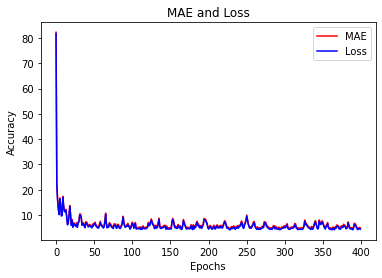

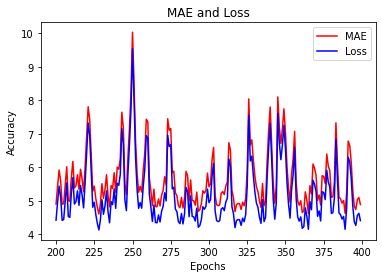

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#<u>**Lesson 2**</u>
# LSTM
So let's edit our code to add another LSTM to see the impact. Now you can see the second layer and note that we had to set return sequences equal to true on the first one in order for this to work.  Now it's tracking much better and closer to the original data.

If we edit our source to add a third LSTM layer like this, by adding the layer and having the second layer return sequences is true we can then train and run it, and we'll get the following output. There's really not that much of a difference and are MAE has actually gone down. 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 7s 23ms/step - loss: 21.9679 - mae: 22.4630
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 21.0787 - mae: 21.5699
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 19.9720 - mae: 20.4666
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 20.5891 - mae: 21.0813
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 20.2777 - mae: 20.7735
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 19.6437 - mae: 20.1366
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 18.2940 - mae: 18.7848
Epoch 8/100
31/31 [==============================] - 1s 23ms/step - loss: 17.2657 - mae: 17.7576
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 17.4906 - mae: 17.9840
Epoch 10/100
31/31 [==============================] - 1s 23ms/step - loss: 16.8689 - mae: 17.3590
Epoch 11/100
31/31 [=========

(1e-08, 0.0001, 0.0, 30.0)

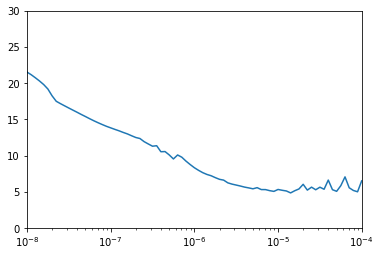

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

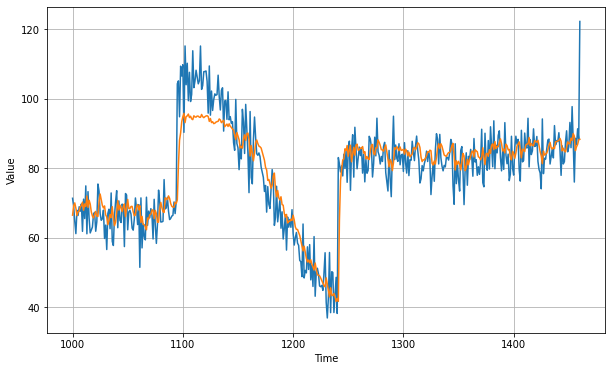

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.366846

<Figure size 432x288 with 0 Axes>

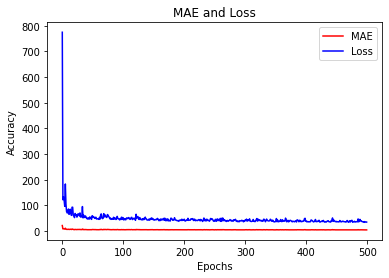

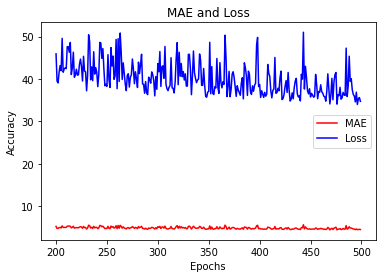

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=0)

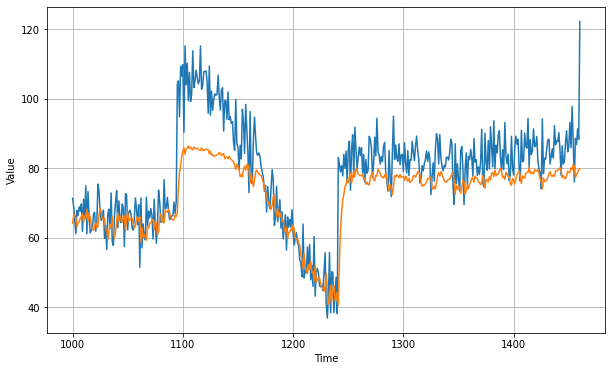

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.6007195

# <u>Exercise 3 - Mean Absolute Error</u>
In class you learned about RNNs and LSTMs for prediction, as well as a simple methodology to pick a decent learning rate for the stochastic gradient descent optimizer. In this exercise you’ll take a synthetic data set and write the code to pick the learning rate and then train on it to get an MAE of < 3

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


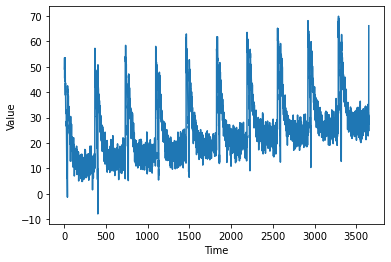

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),# YOUR CODE HERE),
  # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)# YOUR CODE HERE)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 13s 36ms/step - loss: 10.3291 - mae: 10.8109
Epoch 2/100
94/94 [==============================] - 3s 35ms/step - loss: 9.6409 - mae: 10.1169
Epoch 3/100
94/94 [==============================] - 4s 37ms/step - loss: 8.8952 - mae: 9.3758
Epoch 4/100
94/94 [==============================] - 3s 35ms/step - loss: 8.2619 - mae: 8.7398
Epoch 5/100
94/94 [==============================] - 4s 37ms/step - loss: 8.1803 - mae: 8.6584
Epoch 6/100
94/94 [==============================] - 3s 36ms/step - loss: 8.0140 - mae: 8.4974
Epoch 7/100
94/94 [==============================] - 3s 36ms/step - loss: 8.0431 - mae: 8.5269
Epoch 8/100
94/94 [==============================] - 3s 36ms/step - loss: 7.8845 - mae: 8.3685
Epoch 9/100
94/94 [==============================] - 4s 37ms/step - loss: 8.1322 - mae: 8.6198
Epoch 10/100
94/94 [==============================] - 4s 37ms/step - loss: 7.7144 - mae: 8.2007
Epoch 11/100
94/94 [=========================

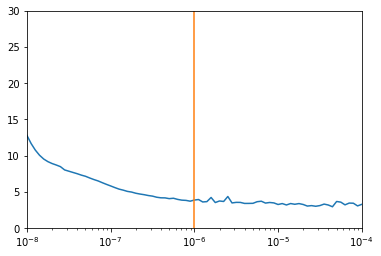

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
x = []
y = []
for i in range(50):
  y.append(i)
for i in range(50):
  x.append(1e-6)
plt.plot(x,y)
# FROM THIS PICK A LEARNING RATE

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),# YOUR CODE HERE),
  # YOUR CODE HERE
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)# YOUR CODE HERE)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mae"])# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=400,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/400
94/94 [==============================] - 13s 37ms/step - loss: 90.8747 - mae: 6.3650
Epoch 2/400
94/94 [==============================] - 3s 35ms/step - loss: 47.5823 - mae: 4.3080
Epoch 3/400
94/94 [==============================] - 3s 35ms/step - loss: 37.0424 - mae: 4.0445
Epoch 4/400
94/94 [==============================] - 4s 38ms/step - loss: 34.5658 - mae: 3.8621
Epoch 5/400
94/94 [==============================] - 3s 35ms/step - loss: 27.4377 - mae: 3.3772
Epoch 6/400
94/94 [==============================] - 3s 35ms/step - loss: 26.5809 - mae: 3.4317
Epoch 7/400
94/94 [==============================] - 3s 35ms/step - loss: 24.5538 - mae: 3.2480
Epoch 8/400
94/94 [==============================] - 3s 36ms/step - loss: 26.9705 - mae: 3.4355
Epoch 9/400
94/94 [==============================] - 4s 37ms/step - loss: 24.9665 - mae: 3.3311
Epoch 10/400
94/94 [==============================] - 3s 36ms/step - loss: 25.7767 - mae: 3.4082
Epoch 11/400
94/94 [==================

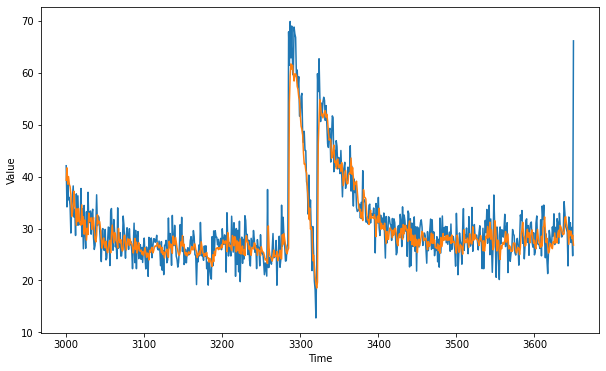

In [9]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.0137935

<Figure size 432x288 with 0 Axes>

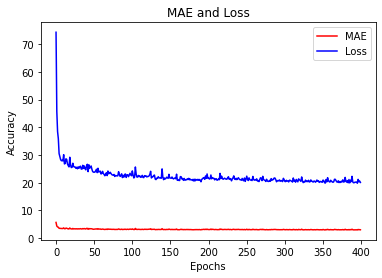

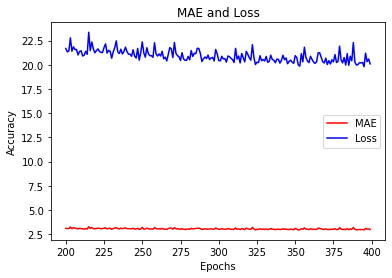

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()